In [1]:
import os
import numpy as np
import pandas as pd


from sklearn.metrics import (r2_score)
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
FIG_SIZE = (8,6)
SAVE_DIR = "../tables/no_desc/"

K_LABELS = {
    0: "Original text",
    1: "Rewrite 1",
    2: "Rewrite 2",
    3: "Rewrite 3",
    4: "Rewrite 4",
    5: "Rewrite 5",
    6: "Rewrite 6"
}

In [ ]:
# The original full dataset processed + its embeddings
df_persuade = pd.read_csv("../data/persuade/persuade_full_cleaned.csv")
full_embeddings = np.load("../embeddings/embeddings_full.npy")

# the low and high scorer output datasets + their embeddings
df_low_scorer = pd.read_csv("../data/low/data_low_no_desc_scored_final.csv")
df_high_scorer = pd.read_csv("../data/high/data_high_no_desc_scored_final.csv")
low_embeddings = np.load("../embeddings/embeddings_low_v2.npy")
high_embeddings = np.load("../embeddings/embeddings_high_v2.npy")

# The results of the scorer run
results_df = pd.read_csv("../data/results/no_desc/no_desc_scored.csv")

# The decomposition results
df_decomp = pd.read_csv("../data/results/decomp_rows_with_fe.csv", index_col=0)

-----

### Distribution of low SES scores and High SES Scores - real (from original persuade, 'holistic_essay_score')

In [ ]:
plt.figure(figsize=FIG_SIZE)

sns.histplot(
    data=df_persuade,
    x="holistic_essay_score",
    hue="economically_disadvantaged",
    bins=np.arange(0.5, 6.5 + 1, 1),
    stat="density",
    multiple="dodge",
    shrink=0.85,
    common_norm=False,
    palette={0: "tab:blue", 1: "tab:orange"},
    legend=False
)

mean_high = df_persuade.loc[df_persuade["economically_disadvantaged"] == 0, "holistic_essay_score"].mean()
mean_low  = df_persuade.loc[df_persuade["economically_disadvantaged"] == 1, "holistic_essay_score"].mean()

plt.axvline(mean_high, color="tab:blue", linestyle="--", linewidth=3)
plt.axvline(mean_low,  color="tab:orange", linestyle="--", linewidth=3)

plt.legend(
    handles=[
        Line2D([0], [0], color="tab:blue", linestyle="--", lw=2, label="High SES"),
        Line2D([0], [0], color="tab:orange", linestyle="--", lw=2, label="Low SES")
    ],
    title="Means"
)


plt.xlabel("Holistic Essay Score")
plt.ylabel("Density")
plt.savefig(f"../tables/new_style/real_scores.png", dpi=300)
plt.tight_layout()
plt.show()


-----

### Mean Score Distribution across Prompt Names

In [ ]:
# --- Mean table ---
mean_table = (
    df_persuade.groupby("prompt_name")["holistic_essay_score"]
    .mean()
    .round(2)
    .reset_index()
    .sort_values("holistic_essay_score", ascending=False)
)
print(mean_table)

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.barplot(
    data=mean_table,
    x="prompt_name",
    y="holistic_essay_score",
)

# Add value labels on top of bars
for i, row in enumerate(mean_table.itertuples()):
    plt.text(
        i, row.holistic_essay_score + 0.02,  # small offset
        f"{row.holistic_essay_score:.2f}",
        ha="center", va="bottom", fontsize=9
    )

plt.title("Mean Holistic Essay Score by Prompt")
plt.xlabel("Prompt Name")
plt.ylabel("Mean Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# --- Wide table: one row per prompt, 3 columns (High, Low, All) showing mean ± SE ---
# Start from your summary_df
pivot = summary_df.pivot(index="prompt_name", columns="SES", values=["mean", "se"])

# Ensure consistent column order
ses_order = ["High SES", "Low SES", "All"]
pivot = pivot.reindex(columns=pd.MultiIndex.from_product([["mean","se"], ses_order]))

# Build a pretty table with "mean ± SE" strings
pretty = pd.DataFrame(index=pivot.index)
rename_map = {"High SES": "High", "Low SES": "Low", "All": "All"}

for ses_in, ses_out in rename_map.items():
    m = pivot[("mean", ses_in)].round(2)
    s = pivot[("se", ses_in)].round(2)
    pretty[ses_out] = m.map(lambda x: f"{x:.2f}" if pd.notna(x) else "nan") + \
                      " ± " + \
                      s.map(lambda x: f"{x:.2f}" if pd.notna(x) else "nan")

# Optional: sort prompts by All mean descending if available
if ("mean", "All") in pivot.columns:
    pretty = pretty.loc[pivot[("mean","All")].sort_values(ascending=False).index]

print(pretty)          # formatted table
# If you also want the numeric MultiIndex table:
# display(pivot.round(2))

In [ ]:
# --- Convert table to image ---
fig, ax = plt.subplots(figsize=(10, 0.6 * len(pretty)))  # adjust height by number of rows
ax.axis("off")

tbl = ax.table(
    cellText=pretty.values,
    colLabels=pretty.columns,
    rowLabels=pretty.index,
    loc="center",
    cellLoc="center"
)

# Make it look nice
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)

plt.title("Mean ± SE Holistic Essay Scores by Prompt (High / Low / All)", pad=15)
plt.tight_layout()

# --- Save as PNG ---
output_path = "../tables/new_style/holistic_scores_table.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Table saved to: {output_path}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# summary_df columns: prompt_name | SES ∈ {"High SES","Low SES","All"} | mean | se
SHOW_ALL = True  # set False to hide the "All" bar

# ---- Pivot once ----
m = summary_df.pivot(index="prompt_name", columns="SES", values="mean")
s = summary_df.pivot(index="prompt_name", columns="SES", values="se")

# Order prompts by "All" mean if present; else by (High+Low)/2
if "All" in m.columns:
    prompt_order = m["All"].sort_values(ascending=False).index
else:
    prompt_order = (m[["High SES","Low SES"]].mean(axis=1)
                    .sort_values(ascending=False, na_position="last").index)

m, s = m.loc[prompt_order], s.loc[prompt_order]
groups = m.index.to_list()
n = len(groups)

# ---- X positions ----
x = np.arange(n)
width = 0.36
offset = width/2 + 0.06
xh = x - offset  # High center
xl = x + offset  # Low center
xa = x           # All center (if shown)

# ---- Colors ----
c_high = "#1f77b4"  # blue
c_low  = "#ff7f0e"  # orange
c_all  = "#888888"  # gray

fig, ax = plt.subplots(figsize=(12, 6))

# ---- Bars + SE ----
if "High SES" in m.columns:
    yh = m["High SES"].to_numpy()
    eh = s.get("High SES", pd.Series(index=m.index, dtype=float)).to_numpy()
    ax.bar(xh, yh, width, label="High SES", color=c_high, zorder=2)
    ax.errorbar(xh, yh, yerr=eh, fmt="none", ecolor="black", elinewidth=1, capsize=3, zorder=3)

if "Low SES" in m.columns:
    yl = m["Low SES"].to_numpy()
    el = s.get("Low SES", pd.Series(index=m.index, dtype=float)).to_numpy()
    ax.bar(xl, yl, width, label="Low SES", color=c_low, zorder=2)
    ax.errorbar(xl, yl, yerr=el, fmt="none", ecolor="black", elinewidth=1, capsize=3, zorder=3)

if SHOW_ALL and "All" in m.columns:
    ya = m["All"].to_numpy()
    ea = s.get("All", pd.Series(index=m.index, dtype=float)).to_numpy()
    ax.bar(xa, ya, width*0.42, label="All", color=c_all, alpha=0.35, zorder=1)
    ax.errorbar(xa, ya, yerr=ea, fmt="none", ecolor="black", elinewidth=1, capsize=2, alpha=0.6, zorder=3)

# ---- Difference brackets (aligned to bar centers) ----
if {"High SES","Low SES"}.issubset(m.columns):
    for i in range(n):
        yA, yB = float(m.iloc[i]["High SES"]), float(m.iloc[i]["Low SES"])
        if np.isnan(yA) or np.isnan(yB): 
            continue

        y_br = max(yA, yB) + 0.08  # baseline of bracket
        h = 0.10                   # bracket height

        # bracket legs at bar centers
        ax.plot([xh[i], xh[i], xl[i], xl[i]],
                [y_br,  y_br + h, y_br + h, y_br],
                color="black", linewidth=1.2, zorder=4)

        # dashed connectors
        ax.plot([xh[i], xh[i]], [yA, y_br], linestyle="--", color="gray", linewidth=1, zorder=4)
        ax.plot([xl[i], xl[i]], [yB, y_br], linestyle="--", color="gray", linewidth=1, zorder=4)

        # centered difference label
        ax.text((xh[i] + xl[i]) / 2, y_br + h + 0.03, f"{abs(yA - yB):.2f}",
                ha="center", va="bottom", fontsize=9)

# ---- Axes/legend ----
ax.set_ylabel("Holistic Essay Score")
ax.set_xlabel("Prompts")
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.grid(axis="y", linestyle=":", alpha=0.4, zorder=0)
ax.set_xlim(x.min() - 0.7, x.max() + 0.7)

handles, labels = ax.get_legend_handles_labels()
order = [labels.index(n) for n in ["High SES","Low SES","All"] if n in labels]
ax.legend([handles[i] for i in order], [labels[i] for i in order], frameon=False)

plt.tight_layout()
plt.show()

----

### 2d Embedding seperate by High SES vs Low SES - t-SNE
    * Generates the image w/ full data
    * Generates the image divided by prompt names

In [ ]:
X_tsne = TSNE(
    n_components=2, metric="cosine", perplexity=30,
    init="random", learning_rate="auto", random_state=42
).fit_transform(full_embeddings)

df_tsne = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "SES": np.where(df_persuade["economically_disadvantaged"], "Low SES", "High SES"),
    "prompt_name": df_persuade["prompt_name"].astype(str)
})

In [ ]:
# --- Plot helper ---
palette_points = {"Low SES": "#7c3aed", "High SES": "#f97316"}

def plot_tsne(d, title=None, save_path=None):
    plt.figure(figsize=FIG_SIZE)
    sns.set_style("white")

    for label in ["Low SES", "High SES"]:
        dd = d[d["SES"] == label]
        if len(dd):
            plt.scatter(dd["x"], dd["y"], s=6, alpha=0.20, color=palette_points[label])

    for label, base_color in [("Low SES", "#7c3aed"), ("High SES", "#f97316")]:
        dd = d[d["SES"] == label]
        if len(dd) < 5:
            continue
        cmap = sns.light_palette(base_color, as_cmap=True)
        sns.kdeplot(data=dd, x="x", y="y", fill=True, thresh=0.02, levels=80, bw_adjust=1.0, alpha=0.75, cmap=cmap)
        sns.kdeplot(data=dd, x="x", y="y", fill=False, levels=7, bw_adjust=1.0, linewidths=1.1, cmap=cmap)

    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    handles = [
        Line2D([0], [0], color="#f97316", lw=3, label="High SES"),
        Line2D([0], [0], color="#7c3aed", lw=3, label="Low SES"),
    ]
    plt.legend(handles=handles, frameon=True)

    if title: 
        plt.title(title)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"../tables/new_style/{save_path}.png", dpi=300)
    
    plt.show()

In [ ]:
plot_tsne(df_tsne, save_path="t_sne_kde")


In [ ]:
def plot_tsne_ax(d, ax, title=None):
    sns.set_style("white")

    # scatter points
    for label in ["Low SES", "High SES"]:
        dd = d[d["SES"] == label]
        if len(dd):
            ax.scatter(dd["x"], dd["y"], s=6, alpha=0.20, color=palette_points[label])

    # KDE layers (guard small/degenerate samples)
    for label, base_color in [("Low SES", "#7c3aed"), ("High SES", "#f97316")]:
        dd = d[d["SES"] == label]
        if len(dd) >= 5 and dd[["x","y"]].std().min() > 0:
            cmap = sns.light_palette(base_color, as_cmap=True)
            try:
                sns.kdeplot(data=dd, x="x", y="y",
                            fill=True, thresh=0.02, levels=80, bw_adjust=1.0,
                            alpha=0.75, cmap=cmap, ax=ax)
                sns.kdeplot(data=dd, x="x", y="y",
                            fill=False, levels=7, bw_adjust=1.0, linewidths=1.1,
                            cmap=cmap, ax=ax)
            except Exception:
                # Some tiny/degenerate clusters can make KDE choke—just skip
                pass

    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    if title:
        ax.set_title(title, fontsize=10)


In [ ]:
prompts = sorted(df_tsne["prompt_name"].unique())
rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(18, 10), constrained_layout=True)
axes = np.ravel(axes)

for i, p in enumerate(prompts):
    d = df_tsne[df_tsne["prompt_name"] == p]
    plot_tsne_ax(d, ax=axes[i], title=f"{p}")

# turn off any unused axes (in case < 15)
for j in range(len(prompts), rows*cols):
    axes[j].axis("off")

# shared legend
shared_handles = [
    Line2D([0], [0], color="#f97316", lw=3, label="High SES"),
    Line2D([0], [0], color="#7c3aed", lw=3, label="Low SES"),
]
fig.legend(handles=shared_handles, loc="upper center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.02))

plt.savefig(f"{SAVE_DIR}tsne_grid_3x5.png", dpi=300, bbox_inches="tight")
plt.show()


----

### Distribution of predicted scores - high vs low SES (overlapped histogram)
    * High Scorer
    * Low Scorer 

In [ ]:
# --- Overlayed histogram helper ---
def overlay_hist(df, col, label, save_name=None, save_dir=None):
    plt.figure(figsize=FIG_SIZE)
    bins = np.linspace(1, 6, 100)

    # High SES
    sns.histplot(
        data=df[df["low_SES"] == 0],
        x=col,
        bins=bins,
        stat="density", 
        element="step",
        fill=True,
        alpha=0.35,
        color="tab:blue",
        label="High SES",
        common_norm=False
    )

    # Low SES
    sns.histplot(
        data=df[df["low_SES"] == 1],
        x=col,
        bins=bins,
        stat="density",  
        element="step",
        fill=True,
        alpha=0.35,
        color="tab:orange",
        label="Low SES",
        common_norm=False
    )

    plt.xlim(1, 6)
    plt.xlabel(f"Predicted Essay Score ({label})")
    plt.ylabel("Density") 
    plt.legend()
    plt.tight_layout()

    if save_name:
        plt.savefig(f"../tables/{save_dir}/{save_name}.png", dpi=300)

    plt.show()
    plt.close()

In [ ]:
# --- Plots ---
overlay_hist(results_df, col="score_high_full", label="High Scorer", save_name="predicted_score_high_scorer", save_dir=SAVE_DIR)
overlay_hist(results_df, col="score_low_full",  label="Low Scorer", save_name="predicted_score_low_scorer", save_dir=SAVE_DIR)

----

### Scatterplot Matrix for predicted scores

In [ ]:
high_cols = [c for c in results_df.columns if c.startswith("score_high")]
low_cols  = [c for c in results_df.columns if c.startswith("score_low")]

def rename_cols(cols):
    return {c: c.split("_")[-1] for c in cols}

sns.set(style="whitegrid", context="talk")

high_df = results_df[high_cols].rename(columns=rename_cols(high_cols))
g1 = sns.pairplot(high_df, diag_kind="kde", plot_kws=dict(s=10, alpha=0.6))
g1.fig.suptitle("Scatterplot Matrix — High SES", y=1.02)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}scatter_matrix_high_ses.png", dpi=300, bbox_inches="tight")
plt.show()

low_df = results_df[low_cols].rename(columns=rename_cols(low_cols))
g2 = sns.pairplot(low_df, diag_kind="kde", plot_kws=dict(s=10, alpha=0.6))
g2.fig.suptitle("Scatterplot Matrix — Low SES", y=1.02)
plt.savefig(f"{SAVE_DIR}scatter_matrix_low_ses.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

-----

### Binned Values - predicted valeu vs estimated mean (Low SES)

In [ ]:
df_low = results_df.query("low_SES == 1").copy()

bins = np.linspace(1, 6, 21)
binned = pd.cut(df_low["score_low_full"], bins=bins, include_lowest=True, right=True)

stats = df_low.groupby(binned, observed=True)["true_score"].agg(["mean", "count", "std"])
stats["se"] = stats["std"] / np.sqrt(stats["count"])
stats.loc[stats["count"] <= 1, "se"] = np.nan
stats["ci"] = 1.96 * stats["se"]

centers = stats.index.map(lambda iv: (iv.left + iv.right) / 2).astype(float)
mask = stats["count"] >= 10

plt.figure(figsize=FIG_SIZE)
plt.plot(centers[mask], stats["mean"][mask], marker="o", color="black")
plt.fill_between(
    centers[mask],
    stats["mean"][mask] - stats["ci"][mask],
    stats["mean"][mask] + stats["ci"][mask],
    alpha=0.3, color="gray"
)
plt.plot([1, 6], [1, 6], "--", alpha=0.4, color="gray")
plt.xlim(1, 6); plt.ylim(1, 6)
plt.xlabel("Predicted essay score"); plt.ylabel("Mean observed score")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(f"{SAVE_DIR}binned_low.png", dpi=300)
plt.show()

----

### Binned Values - predicted valeu vs estimated mean (High SES)

In [ ]:
# Compact binned calibration plot (high SES only)
df_high = results_df.query("low_SES == 0").copy()

bins = np.linspace(1, 6, 21)
binned = pd.cut(df_high["score_high_full"], bins=bins, include_lowest=True, right=True)

stats = df_high.groupby(binned, observed=True)["true_score"].agg(["mean", "count", "std"])
stats["se"] = stats["std"] / np.sqrt(stats["count"])
stats.loc[stats["count"] <= 1, "se"] = np.nan
stats["ci"] = 1.96 * stats["se"]

centers = stats.index.map(lambda iv: (iv.left + iv.right) / 2).astype(float)
mask = stats["count"] >= 10  # keep bins with enough data

plt.figure(figsize=FIG_SIZE)
plt.plot(centers[mask], stats["mean"][mask], marker="o", color="black")
plt.fill_between(
    centers[mask],
    stats["mean"][mask] - stats["ci"][mask],
    stats["mean"][mask] + stats["ci"][mask],
    alpha=0.3, color="gray"
)
plt.plot([1, 6], [1, 6], "--", alpha=0.4, color="gray")
plt.xlim(1, 6); plt.ylim(1, 6)
plt.xlabel("Predicted essay score"); plt.ylabel("Mean observed score")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(f"{SAVE_DIR}binned_high.png", dpi=300)
plt.show()

----

### Share of explained variability - Embedding Vs style Vs raw - R^2 for different scorers (can add the individual metrics also)

In [ ]:
feat_cols = {
    "Emb": "xgb_oof_pred_x_emb",
    "Style": "xgb_oof_pred_x_style",
    "Style + Emb": "xgb_oof_pred_x_full",
}

def r2_by_features(df, y_true_col, mapping):
    y = df[y_true_col]
    return {name: r2_score(y, df[col]) for name, col in mapping.items()}

r2_df = pd.DataFrame({
    "Low SES":  r2_by_features(df_low_scorer,  "holistic_essay_score", feat_cols),
    "High SES": r2_by_features(df_high_scorer, "holistic_essay_score", feat_cols),
})


ax = r2_df.plot(kind="bar", figsize=(8,5), color=["#ff7f0e", "#1f77b4"])
ax.set_ylabel("R² (Explained Variability)")
ax.set_xlabel("Feature Set")
ax.set_ylim(0, 0.9)
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=True)

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}explained_variability.png", dpi=300)
plt.show()

###  Distribution of predicted score - low vs high ses
    * Style 
    * Embedding
    * TAASSC
    * TAACO
    * TAALED
    * PREPROC

In [ ]:
df_plot = results_df.copy()
df_plot["SES"] = np.where(df_plot["low_SES"] == 1, "Low SES", "High SES")

for evals in ["style", "emb", "taaled", "taaco", "taassc"]:
    overlay_hist(df_plot, col=f"score_high_{evals}", label=f"High Scorer {evals}")
    overlay_hist(df_plot, col=f"score_low_{evals}",  label=f"Low Scorer {evals}")

-----

### high SES predicted Valeu vs Low SES predicted value (Includes STD and mean lines)

In [ ]:
# Overlayed predicted-score histograms with mean±std lines (by SES)
bins = np.linspace(1, 6, 40)

hi_mask = results_df["low_SES"] == 0
lo_mask = ~hi_mask

x_hi = results_df.loc[hi_mask, "score_high_full"].dropna()
x_lo = results_df.loc[lo_mask, "score_low_full"].dropna()

plt.figure(figsize=FIG_SIZE)

sns.histplot(x=x_hi, bins=bins, stat="density", element="step",
             fill=True, alpha=0.35, color="tab:blue", label="High SES")
sns.histplot(x=x_lo, bins=bins, stat="density", element="step",
             fill=True, alpha=0.35, color="tab:orange", label="Low SES")

m_hi, s_hi = x_hi.mean(), x_hi.std(ddof=1)
m_lo, s_lo = x_lo.mean(), x_lo.std(ddof=1)

plt.axvline(m_hi, color="tab:blue", alpha=0.8)
plt.axvline(m_hi+s_hi, color="tab:blue", linestyle="--", alpha=0.6)
plt.axvline(m_hi-s_hi, color="tab:blue", linestyle="--", alpha=0.6)

plt.axvline(m_lo, color="tab:orange", alpha=0.8)
plt.axvline(m_lo+s_lo, color="tab:orange", linestyle="--", alpha=0.6)
plt.axvline(m_lo-s_lo, color="tab:orange", linestyle="--", alpha=0.6)

plt.xlim(1, 6)
plt.xlabel("Predicted Essay Score")
plt.ylabel("Density")
plt.legend(title="SES Group")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}predicted_scores_std.png", dpi=300)
plt.show()

-----

### Distribution of rewrites predicted score - high ranker

In [ ]:
# Stable color map by label
_BASE = sns.color_palette("tab10", n_colors=len(K_LABELS))
COLOR_MAP = {K_LABELS[k]: _BASE[i] for i, k in enumerate(sorted(K_LABELS))}

def plot_k_kde(results_df, pred_col, out_png, scorer_note):
    df = results_df[[pred_col, "k"]].dropna().copy()
    df["k"] = df["k"].astype(int)
    df["k_label"] = df["k"].map(K_LABELS)
    df = df[df["k_label"].notna()]

    present = [K_LABELS[k] for k in sorted(df["k"].unique()) if k in K_LABELS]
    pal = [COLOR_MAP[l] for l in present]

    plt.figure(figsize=FIG_SIZE if "FIG_SIZE" in globals() else (8, 6))
    ax = sns.kdeplot(
        data=df,
        x=pred_col,
        hue="k_label",
        hue_order=present,
        palette=pal,
        common_norm=False,
        linewidth=2,
        clip=(1, 6),
    )
    ax.set_xlim(1, 6)
    ax.set_xlabel(f"Predicted Essay Score {scorer_note}")
    ax.set_ylabel("Density")

    # --- Fix existing legend instead of creating new one ---
    leg = ax.get_legend()
    if leg is not None:
        leg.set_title("Version (k)")
        leg.set_bbox_to_anchor((1.02, 1))
        leg._loc = 2  # 'upper left'

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()

In [ ]:
plot_k_kde(results_df, "score_high_full", f"{SAVE_DIR}predicted_scores_k_high_density.png", "(High Scorer)")

------

### Distribution of rewrites predicted score - low ranker

In [ ]:
plot_k_kde(results_df, "score_low_full",  f"{SAVE_DIR}predicted_scores_k_low_density.png",  "(Low Scorer)")

----

### Bar graph of mean prediction for each k X SES

In [ ]:
# --- Prep ---
df = results_df.dropna(subset=["score_high_full", "low_SES", "k"]).copy()
df["k_label"] = df["k"].map(K_LABELS)

# --- Aggregate: mean and standard error by k × SES ---
agg = (
    df.groupby(["k_label", "low_SES"])["score_high_full"]
    .agg(["mean", "count", "std"])
    .reset_index()
)
agg["se"] = agg["std"] / np.sqrt(agg["count"])

# --- Plot ---
plt.figure(figsize=FIG_SIZE)
sns.barplot(
    data=agg,
    x="k_label",
    y="mean",
    hue="low_SES",
    order=list(K_LABELS.values()),
    palette={0: "tab:blue", 1: "tab:orange"},
    capsize=0.15,
    err_kws={"color": "black", "linewidth": 1.5},
    legend=True
)

# --- Styling ---
plt.xlabel("Rewrite Type (k)")
plt.ylabel("Mean Predicted Essay Score")
plt.xticks(rotation=25, ha="right")
plt.yticks(np.arange(1, 7, 1))
plt.ylim(1, 6.1)
plt.legend(
    handles=[
        mpatches.Patch(color="tab:blue", label="High SES"),
        mpatches.Patch(color="tab:orange", label="Low SES")
    ],
    title="SES",
    loc="upper right",
    frameon=True
)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}predicted_k_mean.png", dpi=300)
plt.show()

----

### Distribution of rewrites predicted score based only on style - high ranker

In [ ]:
plot_k_kde(
    results_df,
    pred_col="score_high_style",
    out_png=f"{SAVE_DIR}predicted_scores_k_high_style_density.png",
    scorer_note="(High Scorer) – Style"
)

---- 

### Fixed Effect distribution - (empircal Bayes Correction)

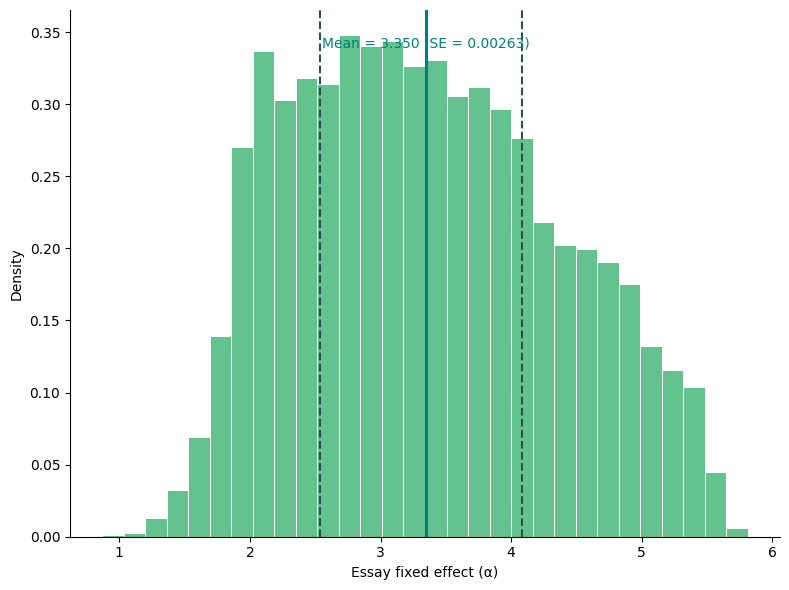

In [24]:
# Drop missing fixed effects (empirical Bayes correction)
x = df_decomp["fe_essay"].dropna()

# Compute stats
mean = x.mean()
se = x.std(ddof=1) / np.sqrt(len(x))
q1, q3 = np.percentile(x, [25, 75])

# --- Plot ---
plt.figure(figsize=FIG_SIZE)
sns.histplot(
    x,
    bins=30,
    color="mediumseagreen",
    stat="density",
    edgecolor="white",
    linewidth=0.7,
    alpha=0.8
)

# Quartile lines
plt.axvline(q1, color="darkslategray", linestyle="--", linewidth=1.5, label="Q1 / Q3")
plt.axvline(q3, color="darkslategray", linestyle="--", linewidth=1.5)

# Mean line (on top)
plt.axvline(mean, color="teal", linewidth=2.2, label="Mean")

# Text label
plt.text(mean, plt.ylim()[1]*0.95,
         f"Mean = {mean:.3f} (SE = {se:.5f})",
         ha="center", va="top", fontsize=10, color="teal")

# Labels and style
plt.xlabel("Essay fixed effect (α)")
plt.ylabel("Density")
sns.despine()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}fixed_effect_distribution.png", dpi=300)
plt.show()


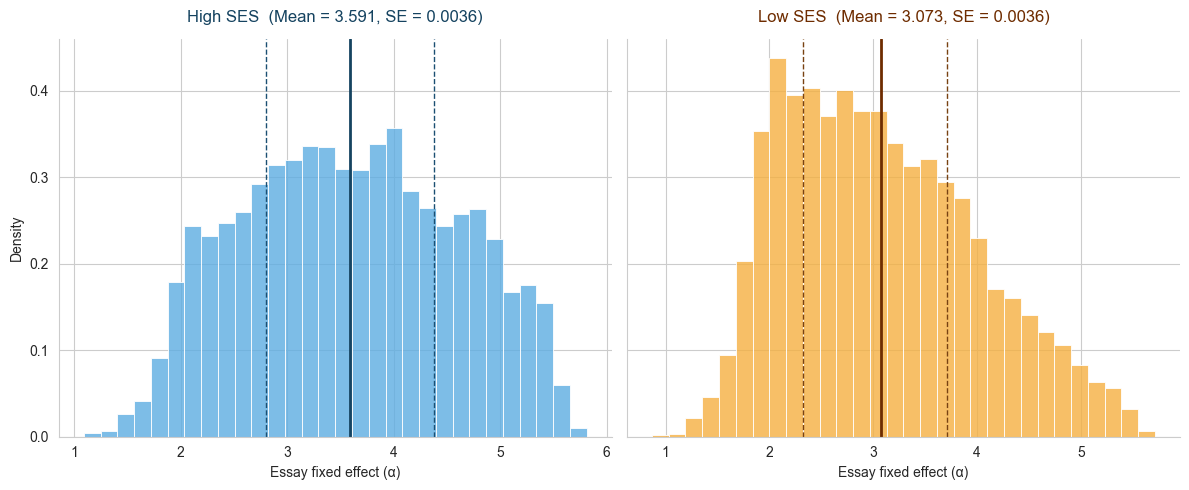

In [30]:
# Drop missing fixed effects
df_plot = df_decomp.dropna(subset=["fe_essay"])

# Split by SES
low_df  = df_plot[df_plot["low_SES"] == 1]["fe_essay"]
high_df = df_plot[df_plot["low_SES"] == 0]["fe_essay"]

# Helper to compute stats
def describe(x):
    return {
        "mean": x.mean(),
        "se": x.std(ddof=1) / np.sqrt(len(x)),
        "q1": np.percentile(x, 25),
        "q3": np.percentile(x, 75),
    }

stats_low  = describe(low_df)
stats_high = describe(high_df)

# --- Create side-by-side figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# ---------- HIGH SES ----------
sns.histplot(
    high_df, bins=30, stat="density",
    color="#5DADE2", edgecolor="white", linewidth=0.6, alpha=0.8, ax=axes[0]
)
axes[0].axvline(stats_high["q1"], color="#1B4F72", linestyle="--", linewidth=1)
axes[0].axvline(stats_high["q3"], color="#1B4F72", linestyle="--", linewidth=1)
axes[0].axvline(stats_high["mean"], color="#154360", linewidth=2)

axes[0].set_title(
    f"High SES  (Mean = {stats_high['mean']:.3f}, SE = {stats_high['se']:.4f})",
    fontsize=12, color="#154360", pad=12
)
axes[0].set_xlabel("Essay fixed effect (α)")
axes[0].set_ylabel("Density")

# ---------- LOW SES ----------
sns.histplot(
    low_df, bins=30, stat="density",
    color="#F5B041", edgecolor="white", linewidth=0.6, alpha=0.8, ax=axes[1]
)
axes[1].axvline(stats_low["q1"], color="#784212", linestyle="--", linewidth=1)
axes[1].axvline(stats_low["q3"], color="#784212", linestyle="--", linewidth=1)
axes[1].axvline(stats_low["mean"], color="#6E2C00", linewidth=2)

axes[1].set_title(
    f"Low SES  (Mean = {stats_low['mean']:.3f}, SE = {stats_low['se']:.4f})",
    fontsize=12, color="#6E2C00", pad=12
)
axes[1].set_xlabel("Essay fixed effect (α)")
axes[1].set_ylabel("")

# --- Styling ---
for ax in axes:
    sns.despine(ax=ax)
    ax.axhline(0, color="gray", lw=0.5)

# fig.suptitle("Distribution of Essay Fixed Effects (α) by SES Group", fontsize=14, y=1.04)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}fixed_effect_distribution_by_SES_dual.png", dpi=300, bbox_inches="tight")
plt.show()

----

### Style distribution - (empircal Bayes Correction)

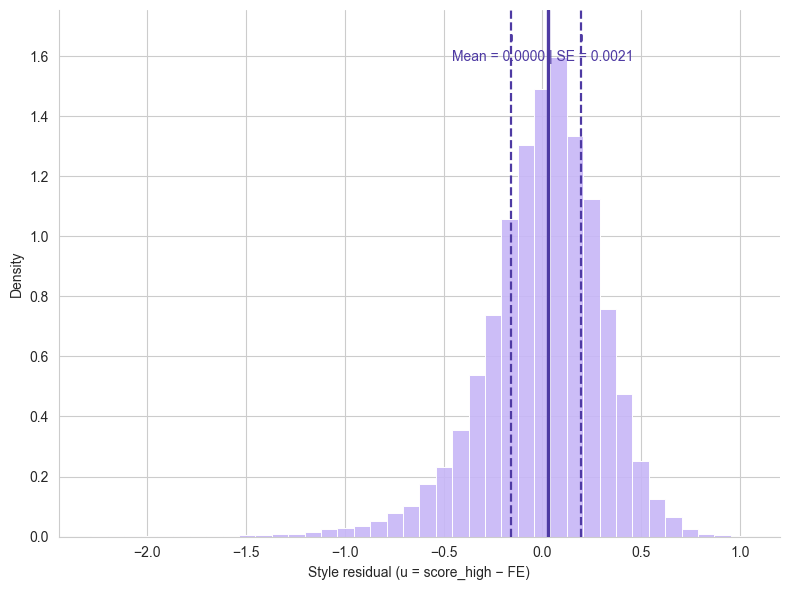

In [27]:
# --- Data (original essays only) ---
mask = (df_decomp["k"] == 0) & df_decomp["u"].notna()
u = df_decomp.loc[mask, "u"].astype(float)

# --- Stats ---
mean = u.mean()
q1, med, q3 = np.percentile(u, [25, 50, 75])
iqr = q3 - q1
se = u.std(ddof=1) / np.sqrt(len(u))  # standard error of the mean

plt.figure(figsize=FIG_SIZE)
sns.set_style("whitegrid")

# Histogram
sns.histplot(
    u, bins=40, stat="density",
    color="#C7B6F7", edgecolor="white", linewidth=0.7, alpha=0.9
)

# Quartile lines (visual guides only)
yl = plt.ylim()
plt.axvline(q1, color="#4E3AA3", linestyle="--", linewidth=1.6, zorder=3)
plt.axvline(q3, color="#4E3AA3", linestyle="--", linewidth=1.6, zorder=3)
plt.axvline(med, color="#4E3AA3", linewidth=2.4, zorder=4, label=f"SE = {se:.4f}")

# Tiny tick marks at top
top = yl[1]
for xline in (q1, med, q3):
    plt.plot([xline, xline], [top*0.985, top*0.995], color="#4E3AA3", linewidth=2, zorder=5, clip_on=False)

# --- Text annotation: now shows mean and SE ---
plt.text(
    mean, top*0.965,
    f"Mean = {mean:.4f} | SE = {se:.4f}",
    ha="center", va="top", fontsize=10, color="#4E3AA3"
)

# Labels / title
plt.xlabel("Style residual (u = score_high − FE)")
plt.ylabel("Density")
sns.despine()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}style_distribution.png", dpi=300)
plt.show()

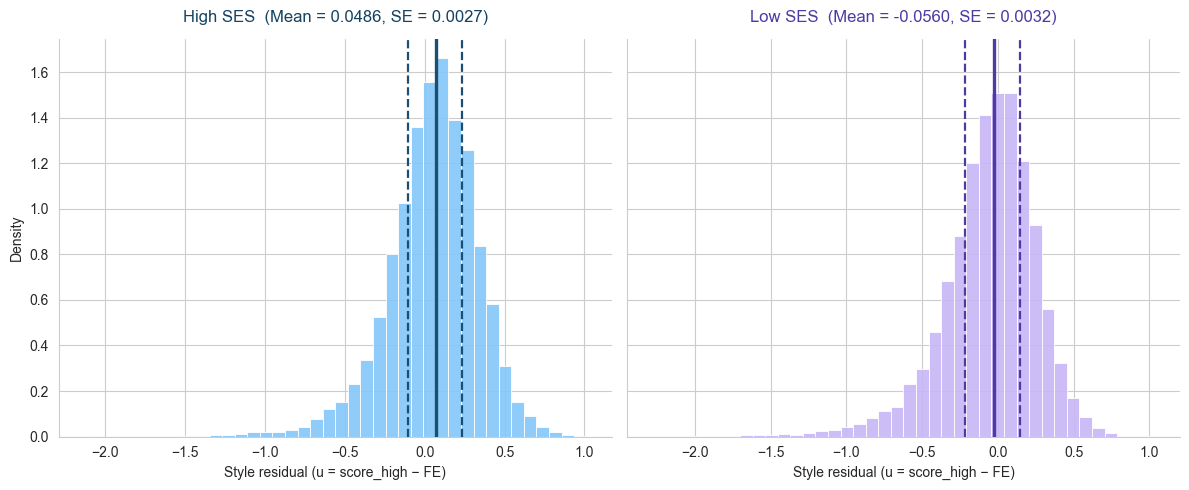

In [29]:
# --- Data (original essays only) ---
mask = (df_decomp["k"] == 0) & df_decomp["u"].notna()
df_u = df_decomp.loc[mask, ["low_SES", "u"]].astype(float)

# Split by SES
u_high = df_u[df_u["low_SES"] == 0]["u"]
u_low  = df_u[df_u["low_SES"] == 1]["u"]

# --- Helper for summary stats ---
def describe(x):
    return {
        "mean": x.mean(),
        "se": x.std(ddof=1) / np.sqrt(len(x)),
        "q1": np.percentile(x, 25),
        "med": np.percentile(x, 50),
        "q3": np.percentile(x, 75),
    }

stats_high = describe(u_high)
stats_low  = describe(u_low)

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.set_style("whitegrid")

# ---------- HIGH SES ----------
sns.histplot(
    u_high, bins=40, stat="density",
    color="#84C7F9", edgecolor="white", linewidth=0.6, alpha=0.9, ax=axes[0]
)
yl = axes[0].get_ylim()
for val, ls, lw in zip(
    [stats_high["q1"], stats_high["med"], stats_high["q3"]],
    ["--", "-", "--"],
    [1.6, 2.4, 1.6],
):
    axes[0].axvline(val, color="#1B4F72", linestyle=ls, linewidth=lw, zorder=3)
axes[0].set_title(
    f"High SES  (Mean = {stats_high['mean']:.4f}, SE = {stats_high['se']:.4f})",
    fontsize=12, color="#154360", pad=12
)
axes[0].set_xlabel("Style residual (u = score_high − FE)")
axes[0].set_ylabel("Density")

# ---------- LOW SES ----------
sns.histplot(
    u_low, bins=40, stat="density",
    color="#C7B6F7", edgecolor="white", linewidth=0.6, alpha=0.9, ax=axes[1]
)
yl = axes[1].get_ylim()
for val, ls, lw in zip(
    [stats_low["q1"], stats_low["med"], stats_low["q3"]],
    ["--", "-", "--"],
    [1.6, 2.4, 1.6],
):
    axes[1].axvline(val, color="#4E3AA3", linestyle=ls, linewidth=lw, zorder=3)
axes[1].set_title(
    f"Low SES  (Mean = {stats_low['mean']:.4f}, SE = {stats_low['se']:.4f})",
    fontsize=12, color="#4E3AA3", pad=12
)
axes[1].set_xlabel("Style residual (u = score_high − FE)")
axes[1].set_ylabel("")

# --- Style ---
for ax in axes:
    sns.despine(ax=ax)
    ax.axhline(0, color="gray", lw=0.5)

# fig.suptitle("Distribution of Style Residuals (u) by SES Group", fontsize=14, y=1.04)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}style_distribution_by_SES_dual.png", dpi=300, bbox_inches="tight")
plt.show()

---

### Decomposition Shares (All, By Gender, by Race, By question)
    * All of them (All, Gender, Race, Question)
    * All + Race + Gender
    * Different Prompts (Questions)

In [21]:
COMP_ORDER = ["content", "style", "others"]
COMP_COLORS = {"content": "#84C7F9", "style": "#C7B6F7", "others": "#B6E3C7"}

# ---------- Core: compute shares ----------
def _mean_mask(s, mask):
    s2 = s[mask & s.notna()]
    return float(s2.mean()) if len(s2) else np.nan

def _compute_decomp(df_sub):
    m_orig = (df_sub["k"] == 0)
    m_hi = m_orig & (df_sub["low_SES"] == 0) & df_sub["score_high_full"].notna()
    m_lo = m_orig & (df_sub["low_SES"] == 1) & df_sub["score_low_full"].notna()
    if not (m_hi.any() and m_lo.any()):
        return pd.Series({c: np.nan for c in COMP_ORDER})

    mean_hi = _mean_mask(df_sub["score_high_full"], m_hi)
    mean_lo = _mean_mask(df_sub["score_low_full"], m_lo)
    total_gap = mean_hi - mean_lo

    content_hi = _mean_mask(df_sub["fe_essay"], m_orig & (df_sub["low_SES"] == 0))
    content_lo = _mean_mask(df_sub["fe_essay"], m_orig & (df_sub["low_SES"] == 1))
    style_hi   = _mean_mask(df_sub["u"], m_orig & (df_sub["low_SES"] == 0))
    style_lo   = _mean_mask(df_sub["u"], m_orig & (df_sub["low_SES"] == 1))

    content_gap = content_hi - content_lo
    style_gap   = style_hi   - style_lo
    others_gap  = total_gap - (content_gap + style_gap)

    if not total_gap:
        return pd.Series({c: np.nan for c in COMP_ORDER})

    return pd.Series({
        "content": content_gap / total_gap,
        "style":   style_gap   / total_gap,
        "others":  others_gap  / total_gap
    })

# ---------- Add grade_level to compute_decomp_shares ----------
def compute_decomp_shares(df_decomp):
    df = df_decomp.copy()

    groups = {"All": df}

    # by race / gender
    for g in ["race_white", "gender_male"]:
        if g in df.columns:
            groups[f"{g}=True"]  = df[df[g] == True]
            groups[f"{g}=False"] = df[df[g] == False]

    # by grade_level (NEW)
    if "grade_level" in df.columns:
        for gl in sorted(df["grade_level"].dropna().unique()):
            groups[f"grade_level={gl}"] = df[df["grade_level"] == gl]

    # by prompt
    if "prompt_name" in df.columns:
        for p in sorted(df["prompt_name"].dropna().unique()):
            groups[f"Prompt: {p}"] = df[df["prompt_name"] == p]

    out = pd.DataFrame({k: _compute_decomp(v) for k, v in groups.items()}).T
    return out.reindex(columns=COMP_ORDER)


# ---------- Plot helpers ----------
def plot_stacked(df_shares, title=None, figsize=(10,6), xtick_rotation=0, save_path=None, label_map=None):
    """
    Draw stacked bar chart of decomposition shares with nicer labels.
    """
    if df_shares.empty:
        print("No data to plot.")
        return

    # Apply mapping for nicer labels (default: GROUP_LABELS)
    if label_map is None:
        label_map = GROUP_LABELS
    df_plot = df_shares.copy()
    df_plot.index = df_plot.index.map(lambda x: label_map.get(x, x))

    ax = df_plot[COMP_ORDER].plot(
        kind="bar",
        stacked=True,
        color=[COMP_COLORS[c] for c in COMP_ORDER],
        edgecolor="white",
        linewidth=0.6,
        figsize=figsize
    )
    ax.set_ylabel("Share of Total SES Gap")
    ax.set_xlabel("")
    ax.set_ylim(0, 1)
    ax.axhline(1, color="gray", lw=0.8, linestyle="--")
    if title:
        ax.set_title(title, pad=10)
    plt.xticks(rotation=xtick_rotation, ha="right" if xtick_rotation else "center")

    ax.legend(
        title="Component",
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False
    )
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def plot_overview(decomp_shares, save_path=None, label_map=None):
    base = ["All", "race_white=True", "race_white=False", "gender_male=True", "gender_male=False"]
    grade_keys = sorted([i for i in decomp_shares.index if i.startswith("grade_level=")])
    want = base + grade_keys  
    overview = decomp_shares.reindex(want).dropna(how="all")
    plot_stacked(overview, figsize=FIG_SIZE, xtick_rotation=45, save_path=save_path, label_map=label_map)


def plot_prompts(decomp_shares, save_path=None, label_map=None):
    prompts = decomp_shares.loc[decomp_shares.index.str.startswith("Prompt: ")].sort_index()
    h = max(5, 0.45 * len(prompts))
    plot_stacked(prompts, figsize=(12, h), xtick_rotation=45, save_path=save_path, label_map=label_map)

In [5]:
# ---------- Group label mapping ----------
GROUP_LABELS = {
    "All": "All",
    "race_white=True": "White",
    "race_white=False": "Non-White",
    "gender_male=True": "Male",
    "gender_male=False": "Female",
    "grade_level=6.0": "Grade 6",
    "grade_level=8.0": "Grade 8",
    "grade_level=9.0": "Grade 9",
    "grade_level=10.0": "Grade 10",
    "grade_level=11.0": "Grade 11",
    "grade_level=12.0": "Grade 12",
}

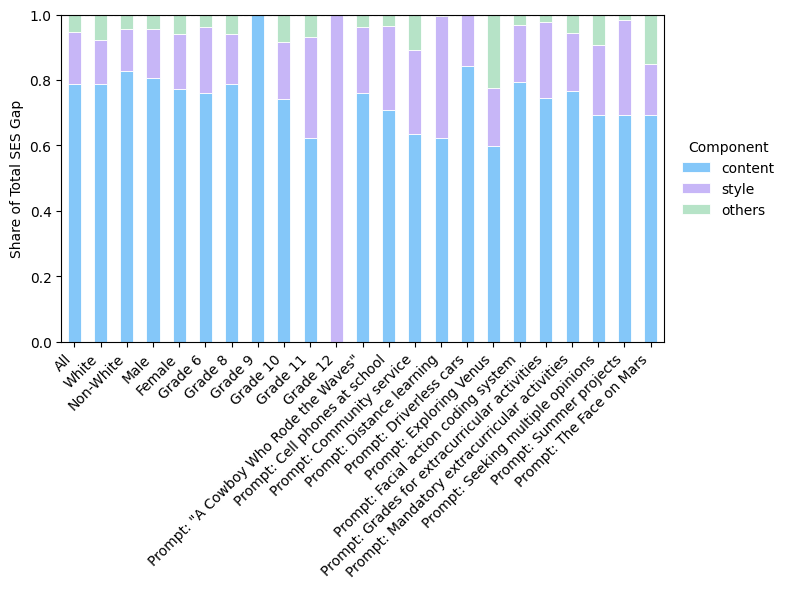

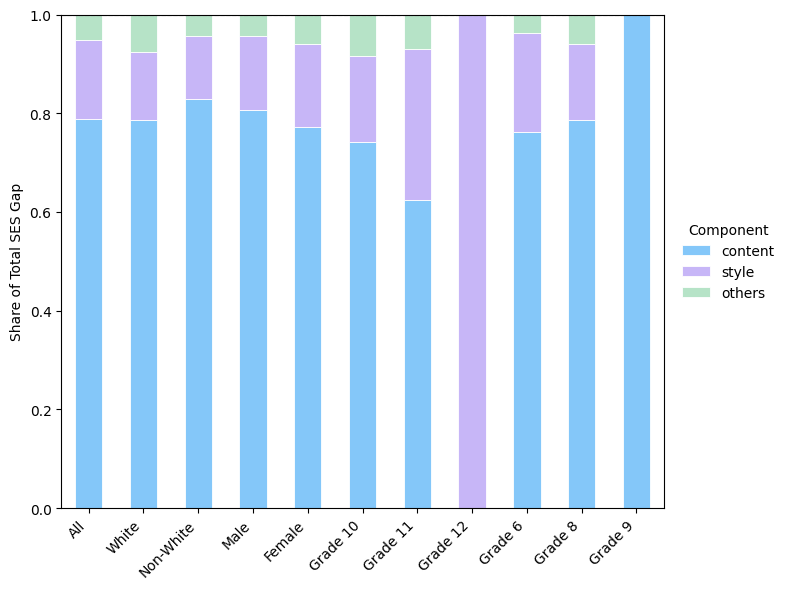

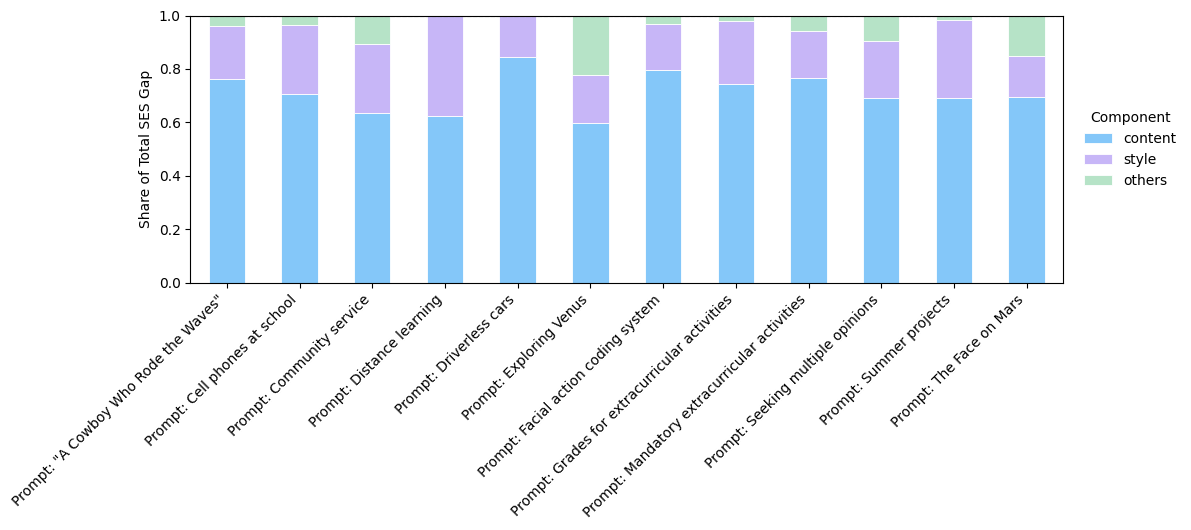

In [22]:
decomp_shares = compute_decomp_shares(df_decomp)

plot_stacked(
    decomp_shares,
    figsize=FIG_SIZE,
    xtick_rotation=45,
    save_path=f"{SAVE_DIR}decomp_shares_all.png",
    label_map=GROUP_LABELS
)

plot_overview(
    decomp_shares,
    save_path=f"{SAVE_DIR}decomp_shares_overview.png",
    label_map=GROUP_LABELS
)

plot_prompts(
    decomp_shares,
    save_path=f"{SAVE_DIR}decomp_shares_prompts.png",
    label_map=GROUP_LABELS
)

In [16]:
# ---------- Core: compute shares with naive SE ----------
def _mean_and_se(s: pd.Series, mask: pd.Series):
    x = s[mask & s.notna()].astype(float)
    n = x.size
    if n == 0:
        return np.nan, np.nan, 0
    mean = float(x.mean())
    # sample std with ddof=1; if n==1, fallback to 0.0
    sd = float(x.std(ddof=1)) if n > 1 else 0.0
    se = sd / np.sqrt(n) if n > 0 else np.nan
    return mean, se, n

def _compute_decomp_with_se(df_sub):
    # restrict to k==0 as in your logic
    m_k0 = (df_sub["k"] == 0)

    # hi / lo masks for availability
    m_hi = m_k0 & (df_sub["low_SES"] == 0)
    m_lo = m_k0 & (df_sub["low_SES"] == 1)

    # require that both groups exist and have data
    if not (m_hi.any() and m_lo.any()):
        return pd.Series(
            {**{c: np.nan for c in COMP_ORDER},
             **{f"se_{c}": np.nan for c in COMP_ORDER}}
        )

    # Means and SEs for the *observables* used in each component
    # Total gap uses score_high_full (hi) vs score_low_full (lo)
    mean_hi_full, se_hi_full, _ = _mean_and_se(df_sub["score_high_full"], m_hi & df_sub["score_high_full"].notna())
    mean_lo_full, se_lo_full, _ = _mean_and_se(df_sub["score_low_full"],  m_lo & df_sub["score_low_full"].notna())
    total_gap = mean_hi_full - mean_lo_full
    var_total = se_hi_full**2 + se_lo_full**2  # naive, ignores covariance
    se_total = np.sqrt(var_total)

    # Content uses fe_essay (hi vs lo)
    mean_hi_cont, se_hi_cont, _ = _mean_and_se(df_sub["fe_essay"], m_hi & df_sub["fe_essay"].notna())
    mean_lo_cont, se_lo_cont, _ = _mean_and_se(df_sub["fe_essay"], m_lo & df_sub["fe_essay"].notna())
    content_gap = mean_hi_cont - mean_lo_cont
    var_content = se_hi_cont**2 + se_lo_cont**2
    se_content_gap = np.sqrt(var_content)

    # Style uses u (hi vs lo)
    mean_hi_style, se_hi_style, _ = _mean_and_se(df_sub["u"], m_hi & df_sub["u"].notna())
    mean_lo_style, se_lo_style, _ = _mean_and_se(df_sub["u"], m_lo & df_sub["u"].notna())
    style_gap = mean_hi_style - mean_lo_style
    var_style = se_hi_style**2 + se_lo_style**2
    se_style_gap = np.sqrt(var_style)

    # Others = total - content - style
    others_gap = total_gap - (content_gap + style_gap)
    # naive var(others) = var(total) + var(content) + var(style) (ignoring covariances and signs)
    var_others = var_total + var_content + var_style
    se_others_gap = np.sqrt(var_others)

    # Guard against divide-by-zero / nan
    if not (pd.notna(total_gap) and total_gap != 0):
        return pd.Series(
            {**{c: np.nan for c in COMP_ORDER},
             **{f"se_{c}": np.nan for c in COMP_ORDER}}
        )

    # Shares
    content_share = content_gap / total_gap
    style_share   = style_gap   / total_gap
    others_share  = others_gap  / total_gap

    # Naive delta-method SEs for shares: r = g / T, Var(r) ≈ (1/T^2)Var(g) + (g^2/T^4)Var(T)
    T = total_gap
    T2, T4 = T**2, T**4
    se_share_content = np.sqrt((var_content / T2) + (content_gap**2 * var_total / T4))
    se_share_style   = np.sqrt((var_style   / T2) + (style_gap**2   * var_total / T4))
    se_share_others  = np.sqrt((var_others  / T2) + (others_gap**2  * var_total / T4))

    return pd.Series({
        "content": content_share,
        "style":   style_share,
        "others":  others_share,
        "se_content": se_share_content,
        "se_style":   se_share_style,
        "se_others":  se_share_others
    })

def compute_decomp_shares_with_se(df_decomp):
    df = df_decomp.copy()

    groups = {"All": df}

    # by race / gender (as before)
    for g in ["race_white", "gender_male"]:
        if g in df.columns:
            groups[f"{g}=True"]  = df[df[g] == True]
            groups[f"{g}=False"] = df[df[g] == False]

    # by grade_level (NEW)
    if "grade_level" in df.columns:
        # sort unique grade values (handles float like 6.0, 8.0, ...)
        for gl in sorted(df["grade_level"].dropna().unique()):
            groups[f"grade_level={gl}"] = df[df["grade_level"] == gl]

    # by prompt_name (as before)
    if "prompt_name" in df.columns:
        for p in sorted(df["prompt_name"].dropna().unique()):
            groups[f"Prompt: {p}"] = df[df["prompt_name"] == p]

    out = pd.DataFrame({k: _compute_decomp_with_se(v) for k, v in groups.items()}).T
    cols = COMP_ORDER + [f"se_{c}" for c in COMP_ORDER]
    return out.reindex(columns=cols)


In [18]:
decomp_shares_se = compute_decomp_shares_with_se(df_decomp)

# After computing decomp_shares_se with SE columns
table_fmt = decomp_shares_se.copy()

# Round to 2 decimals
for c in COMP_ORDER + [f"se_{c}" for c in COMP_ORDER]:
    table_fmt[c] = table_fmt[c].round(2)

# Combine share ± SE into one string per component
for comp in COMP_ORDER:
    se_col = f"se_{comp}"
    table_fmt[comp] = table_fmt.apply(
        lambda r: f"{r[comp]} ± {r[se_col]}" if pd.notna(r[comp]) and pd.notna(r[se_col]) else np.nan,
        axis=1
    )

# Drop separate SE columns for cleaner output (optional)
table_fmt = table_fmt[COMP_ORDER]

# Apply label mapping for readability
table_fmt.index = table_fmt.index.map(lambda x: GROUP_LABELS.get(x, x))

# Save or display
table_fmt.to_csv(f"{SAVE_DIR}decomp_shares_tables.csv")
table_fmt.to_latex(f"{SAVE_DIR}decomp_shares_tables.tex")
display(table_fmt)


,content,style,others
All,0.79 ± 0.03,0.16 ± 0.01,0.05 ± 0.03
White,0.79 ± 0.05,0.14 ± 0.01,0.08 ± 0.06
Non-White,0.83 ± 0.04,0.13 ± 0.01,0.04 ± 0.04
Male,0.81 ± 0.04,0.15 ± 0.01,0.04 ± 0.04
Female,0.77 ± 0.03,0.17 ± 0.01,0.06 ± 0.04
Grade 6,0.76 ± 0.18,0.2 ± 0.07,0.04 ± 0.21
Grade 8,0.79 ± 0.04,0.15 ± 0.01,0.06 ± 0.04
Grade 9,11.45 ± 569.34,-3.88 ± 193.73,-6.58 ± 334.13
Grade 10,0.74 ± 0.05,0.18 ± 0.02,0.08 ± 0.06
Grade 11,0.62 ± 0.07,0.31 ± 0.03,0.07 ± 0.09
